In [1]:
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import utm

## Dataset Path
rosbag = 'my_ros2_bag_data/my_ros2_bag_data.db3' 
storage_id = 'sqlite3'

## Setup Reader
reader = rosbag2_py.SequentialReader()
storage_options = rosbag2_py.StorageOptions(uri=rosbag, storage_id=storage_id)
converter_options = rosbag2_py.ConverterOptions(
    input_serialization_format='cdr',
    output_serialization_format='cdr'
)
reader.open(storage_options, converter_options)

## Get Topic Types (needed for deserialization)
topic_types = reader.get_all_topics_and_types()
type_map = {t.name: t.type for t in topic_types}

gps_list = []
imu_list = []

## Loop through messages
while reader.has_next():
    (topic, data, timestamp) = reader.read_next()
    
    if topic in ['/gps/fix', '/imu/imu_uncompensated']:
        msg_type = get_message(type_map[topic])
        msg = deserialize_message(data, msg_type)
        
        if topic == '/gps/fix':
            gps_list.append({
                'Time': timestamp * 1e-9,
                'latitude': msg.latitude,
                'longitude': msg.longitude,
                'altitude': msg.altitude
            })
            
        elif topic == '/imu/imu_uncompensated':
            imu_list.append({
                'Time': timestamp * 1e-9,
                'linear_acceleration.x': msg.linear_acceleration.x,
                'linear_acceleration.y': msg.linear_acceleration.y,
                'linear_acceleration.z': msg.linear_acceleration.z,
                'angular_velocity.x': msg.angular_velocity.x,
                'angular_velocity.y': msg.angular_velocity.y,
                'angular_velocity.z': msg.angular_velocity.z
            })

## Create DataFrames
gpsData = pd.DataFrame(gps_list)
imuData = pd.DataFrame(imu_list)

print(f"Loaded {len(gpsData)} GPS points and {len(imuData)} IMU points.")

[INFO] [1767830894.490413356] [rosbag2_storage]: Opened database 'my_ros2_bag_data/my_ros2_bag_data.db3' for READ_ONLY.


Loaded 30758 GPS points and 616322 IMU points.


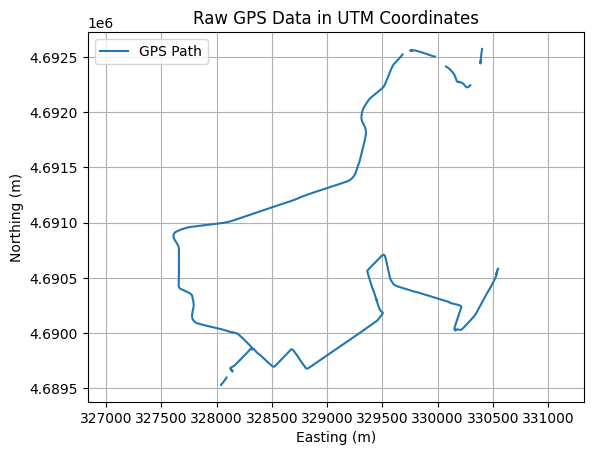

In [2]:
## Plot raw GPS data in UTM coordinates 
## Convert latitude and longitude to UTM coordinates
timegps = gpsData["Time"]-gpsData["Time"][0] # Time vector starting from 0

Easting = []
Northing = []

for lat, lon in zip(gpsData["latitude"],gpsData["longitude"]):
    if pd.isna(lat) and pd.isna(lon):
        Easting.append(lat)
        Northing.append(lon)
    else:
        east, north, _, _ = utm.from_latlon(lat, lon)
        Easting.append(east)
        Northing.append(north)

## Plotting the raw GPS data
plt.figure()
plt.plot(Easting, Northing, label='GPS Path')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Raw GPS Data in UTM Coordinates')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

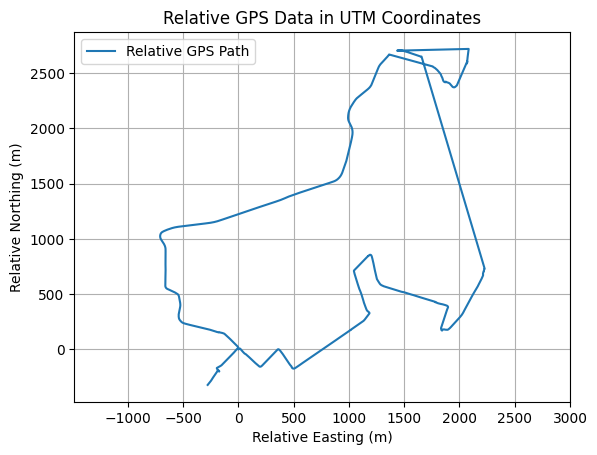

In [3]:
## Plot the raw GPS data in relative coordinates (shifted to start at origin)
# Handle NaN values by interpolation
current_value=Easting[2737]
for i in range(len(Easting)):
    if not np.isnan(Easting[i]):
        current_value = Easting[i]
    else:
        Easting[i] = current_value

current_value=Northing[2737]
for i in range(len(Northing)):
    if not np.isnan(Northing[i]):
        current_value=Northing[i]
    else:
        Northing[i]=current_value

Easting_rel = [e - Easting[0] for e in Easting]
Northing_rel = [n - Northing[0] for n in Northing]
plt.figure()
plt.plot(Easting_rel, Northing_rel, label='Relative GPS Path')
plt.xlabel('Relative Easting (m)')
plt.ylabel('Relative Northing (m)')
plt.title('Relative GPS Data in UTM Coordinates')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

Biases Found: Ax=-0.5181, Ay=0.0059, Wz=-0.0362


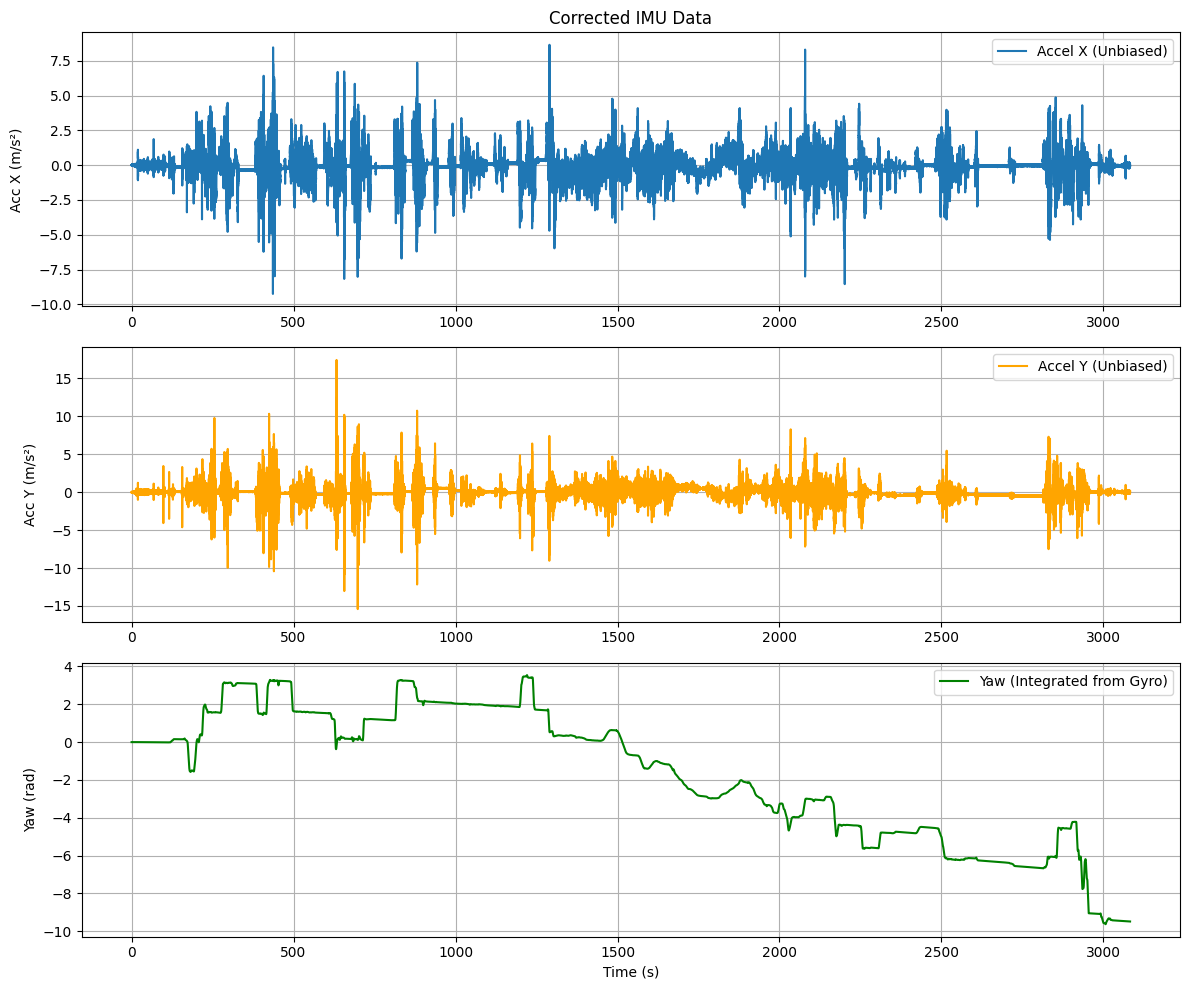

In [4]:
## PREPARE TIME
timeimu = imuData["Time"].values - imuData["Time"].values[0]
diffs = np.diff(timeimu, prepend=0)


## REMOVE BIAS (Calibrate sensors)
# We assume the car was STATIONARY for the first 2 seconds.
# We take the average of that "quiet time" and subtract it.
init_samples = 200

accel_x = imuData["linear_acceleration.x"].values
accel_y = imuData["linear_acceleration.y"].values
gyro_z = imuData["angular_velocity.z"].values

## Calculate Bias
accel_x_bias = np.mean(accel_x[:init_samples])
accel_y_bias = np.mean(accel_y[:init_samples])
gyro_z_bias = np.mean(gyro_z[:init_samples])

## Remove Bias
accel_x_unbiased = accel_x - accel_x_bias
accel_y_unbiased = accel_y - accel_y_bias
gyro_z_unbiased = gyro_z - gyro_z_bias

print(f"Biases Found: Ax={accel_x_bias:.4f}, Ay={accel_y_bias:.4f}, Wz={gyro_z_bias:.4f}")

## CALCULATE APPROXIMATE YAW (For Plotting Only)
# Since we don't have Quaternions, we "integrate" the gyro rate.
# Angle = Rate * Time
yaw_integrated = np.cumsum(gyro_z_unbiased * diffs)

## PLOTTING
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(timeimu, accel_x_unbiased, label='Accel X (Unbiased)')
plt.title('Corrected IMU Data')
plt.ylabel('Acc X (m/s²)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(timeimu, accel_y_unbiased, label='Accel Y (Unbiased)', color='orange')
plt.ylabel('Acc Y (m/s²)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(timeimu, yaw_integrated, label='Yaw (Integrated from Gyro)', color='green')
plt.ylabel('Yaw (rad)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
class EKF2D:
    def __init__(self):
        # State Vector x: [pos_x, pos_y, theta, v]
        self.x = np.zeros(4)
        
        # Covariance Matrix P: 4x4, initialized with high uncertainty
        self.P = np.eye(4) * 100.0
        
        # Process Noise Matrix Q: How much we trust the physics
        # (Tune these values if the path is too jittery or too slow)
        self.Q = np.diag([0.01, 0.01, 0.001, 0.01])

        # Measurement Noise Matrix R: How much we trust the GPS
        self.R = np.eye(2) * 5.0

    def predict(self, u, dt):
        # 1. Unpack State
        px = self.x[0]
        py = self.x[1]
        theta = self.x[2]
        v = self.x[3]
        
        # 2. Unpack Control Inputs
        # u[0] = acceleration, u[1] = yaw_rate
        a = u[0]
        omega = u[1]
        
        # 3. Physics Model (Non-linear)
        new_theta = theta + omega * dt
        new_v = v + a * dt
        new_px = px + v * np.cos(theta) * dt
        new_py = py + v * np.sin(theta) * dt
        
        # 4. Jacobian Matrix F (Linearization)
        F = np.eye(4)
        F[0, 2] = -v * np.sin(theta) * dt  # d(px)/d(theta)
        F[0, 3] = np.cos(theta) * dt       # d(px)/d(v)
        F[1, 2] = v * np.cos(theta) * dt   # d(py)/d(theta)
        F[1, 3] = np.sin(theta) * dt       # d(py)/d(v)
        
        # 5. Predict State and Covariance
        self.x = np.array([new_px, new_py, new_theta, new_v])
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        # z is the GPS measurement [easting, northing]
        
        # 1. Measurement Matrix H (2x4)
        # We measure x and y, but ignore theta and v
        H = np.zeros((2, 4))
        H[0, 0] = 1
        H[1, 1] = 1
        
        # 2. Innovation (Error)
        y = z - H @ self.x
        
        # 3. Innovation Covariance S
        S = H @ self.P @ H.T + self.R
        
        # 4. Kalman Gain K
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # 5. Update State and Covariance
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ H) @ self.P

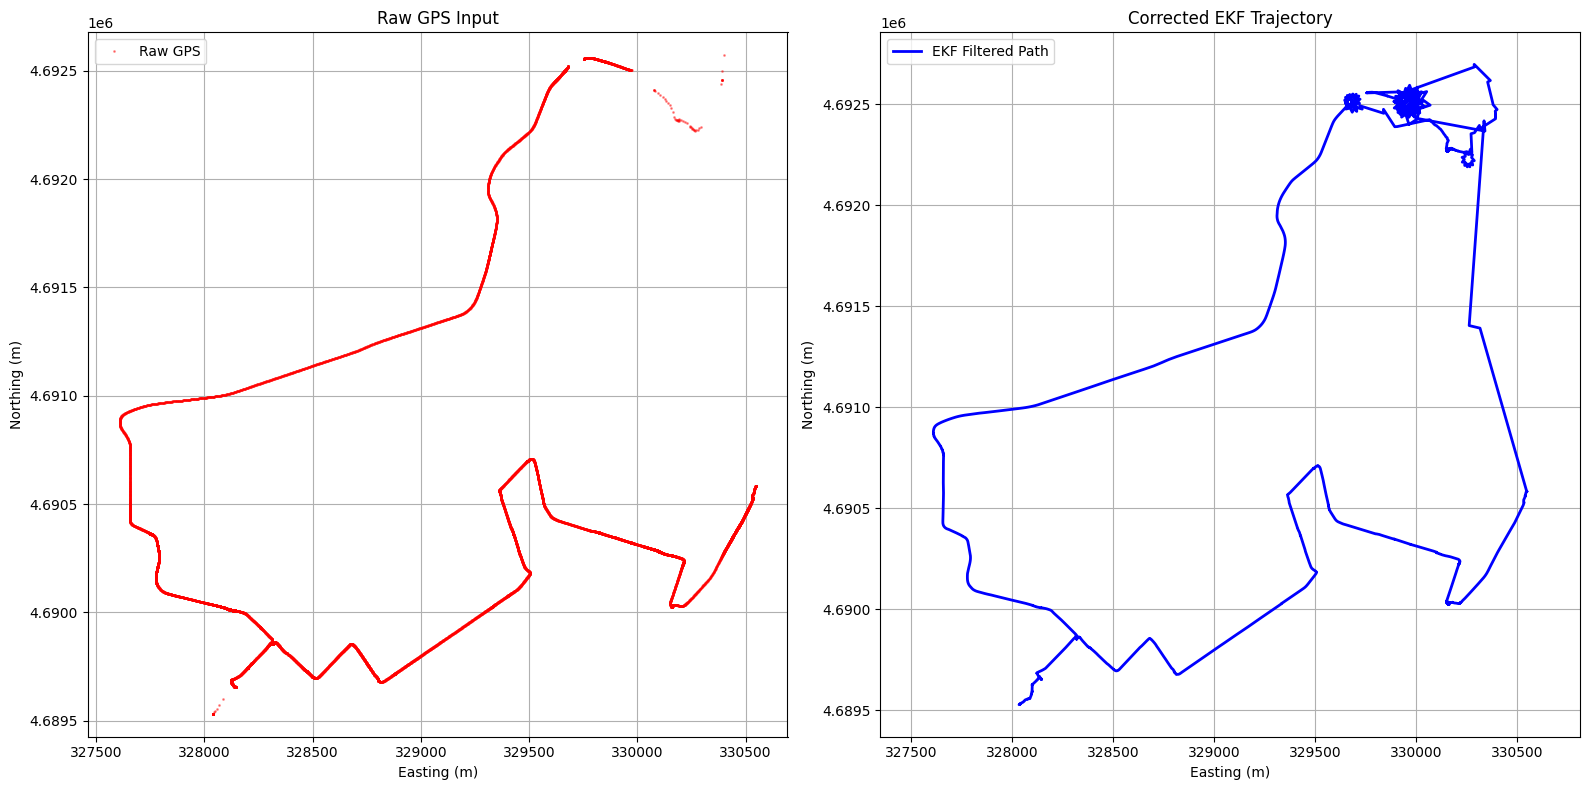

In [15]:
ekf = EKF2D()

# Set initial Position
ekf.x[0], ekf.x[1] = gps_easting[0], gps_northing[0]

# FIX: Calculate initial heading from movement to avoid the "starting hook"
dx = gps_easting[10] - gps_easting[0]
dy = gps_northing[10] - gps_northing[0]
ekf.x[2] = np.arctan2(dy, dx)
ekf.x[3] = 0.0 # Initial velocity

# 

# Logs for plotting
est_x, est_y, est_theta = [], [], []
std_x, std_y, std_theta, std_v = [], [], [], []
next_gps_idx = 0

ekf_at_gps = [] 
gps_reference_points = []

# ---------------------------------------------------------
# 4. MAIN EKF LOOP
# ---------------------------------------------------------
for i in range(len(timeimu)):
    # Calculate Dynamic dt
    dt = 0.01
    if i > 0:
        dt = timeimu[i] - timeimu[i-1]
    if dt <= 0: continue

    # Prediction (IMU)
    u = [accel_x_unbiased[i], gyro_z_unbiased[i]]
    ekf.predict(u, dt)
    
    # Correction (Asynchronous GPS)
    current_time = timeimu[i]
    if next_gps_idx < len(gps_time):
        if current_time >= gps_time[next_gps_idx]:
            z = np.array([gps_easting[next_gps_idx], gps_northing[next_gps_idx]])
            ekf.update(z)
            # Save the EKF position and the GPS ground truth at this exact moment
            ekf_at_gps.append([ekf.x[0], ekf.x[1]])
            gps_reference_points.append(z)
            next_gps_idx += 1
            
    # Log Results
    est_x.append(ekf.x[0])
    est_y.append(ekf.x[1])
    est_theta.append(ekf.x[2])
    
    # Log Uncertainty (Standard Deviation = sqrt of variance)
    std_x.append(np.sqrt(ekf.P[0, 0]))
    std_y.append(np.sqrt(ekf.P[1, 1]))
    std_theta.append(np.sqrt(ekf.P[2, 2]))
    std_v.append(np.sqrt(ekf.P[3, 3]))

# ---------------------------------------------------------
# 4. PLOTTING
# ---------------------------------------------------------
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(gps_easting, gps_northing, 'r.', markersize=2, alpha=0.4, label='Raw GPS')
plt.title('Raw GPS Input')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.axis('equal')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(est_x, est_y, 'b-', linewidth=2, label='EKF Filtered Path')
plt.title('Corrected EKF Trajectory')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.axis('equal') 
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

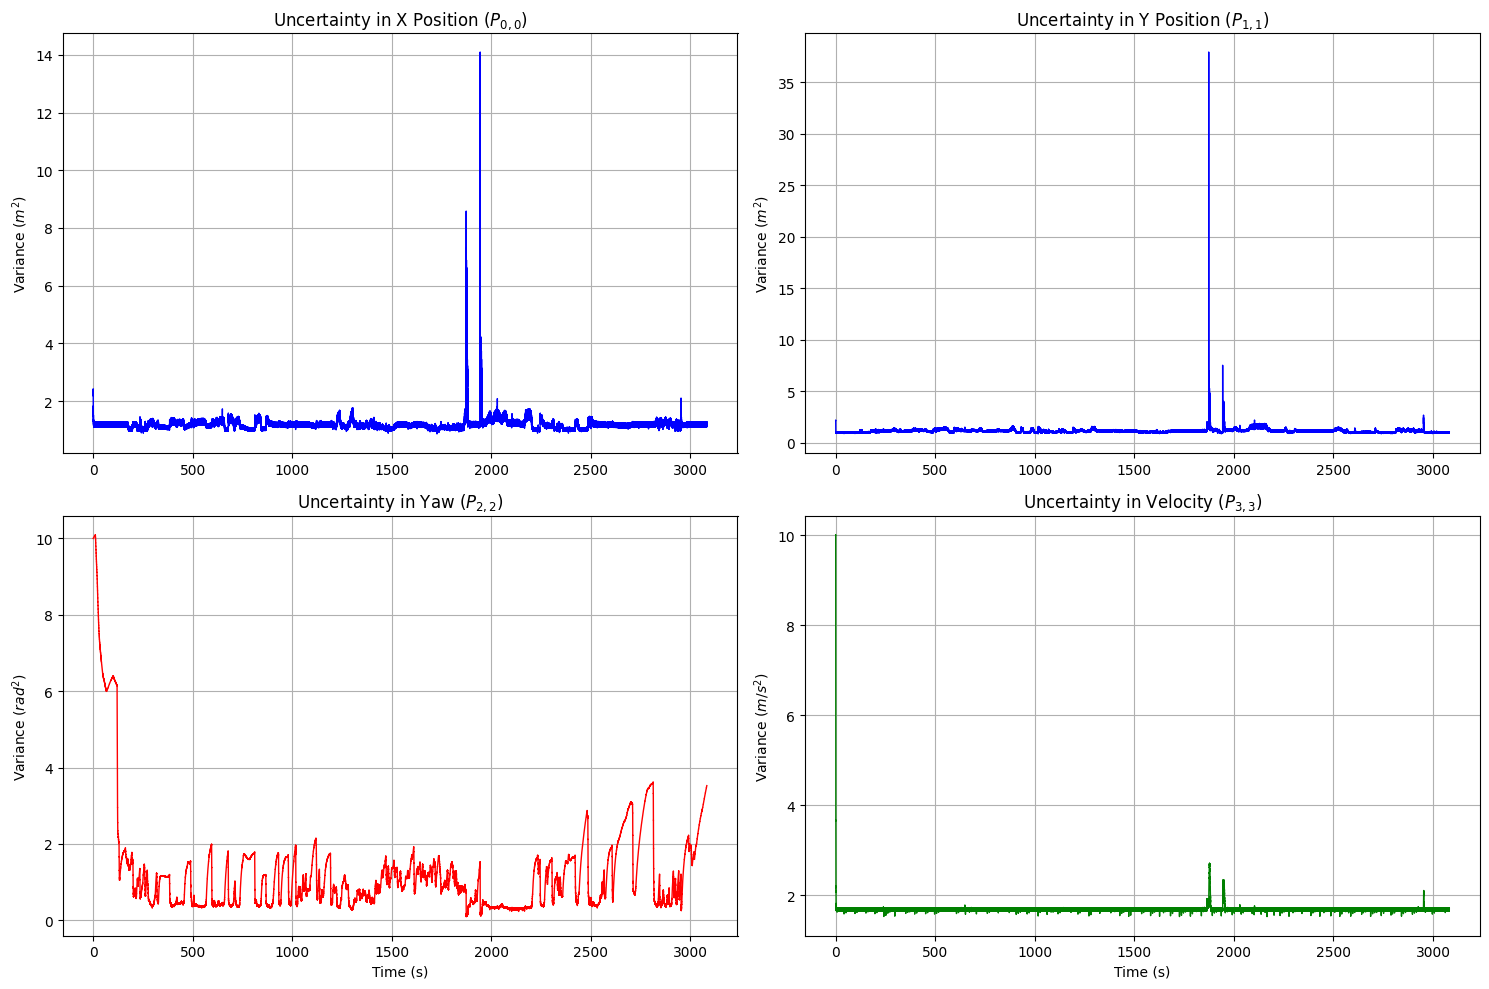

In [16]:
## PLOT COVARIANCE (UNCERTAINTY)
plt.figure(figsize=(15, 10))

# Plot Uncertainty in Position X
plt.subplot(2, 2, 1)
plt.plot(timeimu, std_x, 'b-', linewidth=1)
plt.title('Uncertainty in X Position ($P_{0,0}$)')
plt.ylabel('Variance ($m^2$)')
plt.grid(True)

# Plot Uncertainty in Position Y
plt.subplot(2, 2, 2)
plt.plot(timeimu, std_y, 'b-', linewidth=1)
plt.title('Uncertainty in Y Position ($P_{1,1}$)')
plt.ylabel('Variance ($m^2$)')
plt.grid(True)

# Plot Uncertainty in Theta
plt.subplot(2, 2, 3)
plt.plot(timeimu, std_theta, 'r-', linewidth=1)
plt.title('Uncertainty in Yaw ($P_{2,2}$)')
plt.ylabel('Variance ($rad^2$)')
plt.xlabel('Time (s)')
plt.grid(True)

# Plot Uncertainty in Velocity
plt.subplot(2, 2, 4)
plt.plot(timeimu, std_v, 'g-', linewidth=1)
plt.title('Uncertainty in Velocity ($P_{3,3}$)')
plt.ylabel('Variance ($m/s^2$)')
plt.xlabel('Time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

EKF Performance Metrics (vs 30758 GPS points):
RMSE:       8.2504 meters
Mean Error: 0.4012 meters
Max Error:  1162.2383 meters


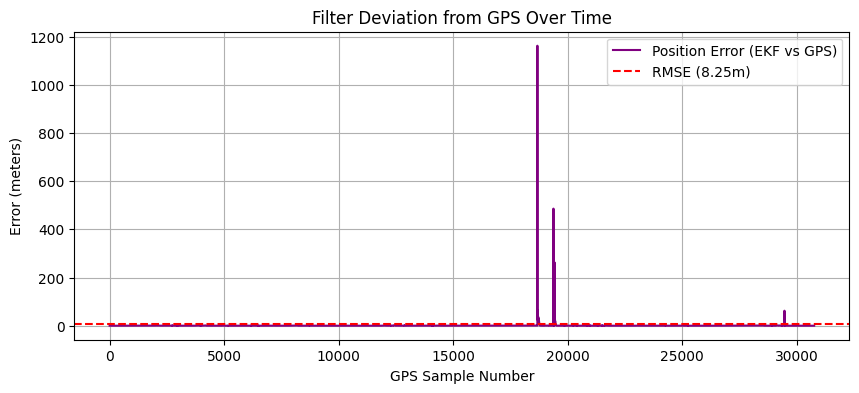

In [18]:
# Convert to numpy arrays
# atleast_2d ensures that even a single point is treated as [[x, y]]
ekf_at_gps = np.atleast_2d(ekf_at_gps)
gps_ref = np.atleast_2d(gps_reference_points)

# Safety check: Ensure we actually have data to compare
if ekf_at_gps.shape[0] > 0 and ekf_at_gps.shape == gps_ref.shape:
    
    # Calculate Euclidean Distance Error for each point
    # We use axis=-1 to be safe for both 1D and 2D arrays
    errors = np.linalg.norm(ekf_at_gps - gps_ref, axis=-1)

    # 1. RMSE (Root Mean Square Error)
    rmse = np.sqrt(np.mean(errors**2))

    # 2. MAE (Mean Absolute Error)
    mae = np.mean(errors)

    # 3. Max Error
    max_error = np.max(errors)

    print(f"EKF Performance Metrics (vs {len(errors)} GPS points):")
    print(f"RMSE:       {rmse:.4f} meters")
    print(f"Mean Error: {mae:.4f} meters")
    print(f"Max Error:  {max_error:.4f} meters")

    # Plot the error over time
    plt.figure(figsize=(10, 4))
    plt.plot(errors, color='purple', label='Position Error (EKF vs GPS)')
    plt.axhline(y=rmse, color='r', linestyle='--', label=f'RMSE ({rmse:.2f}m)')
    plt.title('Filter Deviation from GPS Over Time')
    plt.xlabel('GPS Sample Number')
    plt.ylabel('Error (meters)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Error: No overlapping EKF/GPS data found. Check if your loop is correctly appending to the lists.")

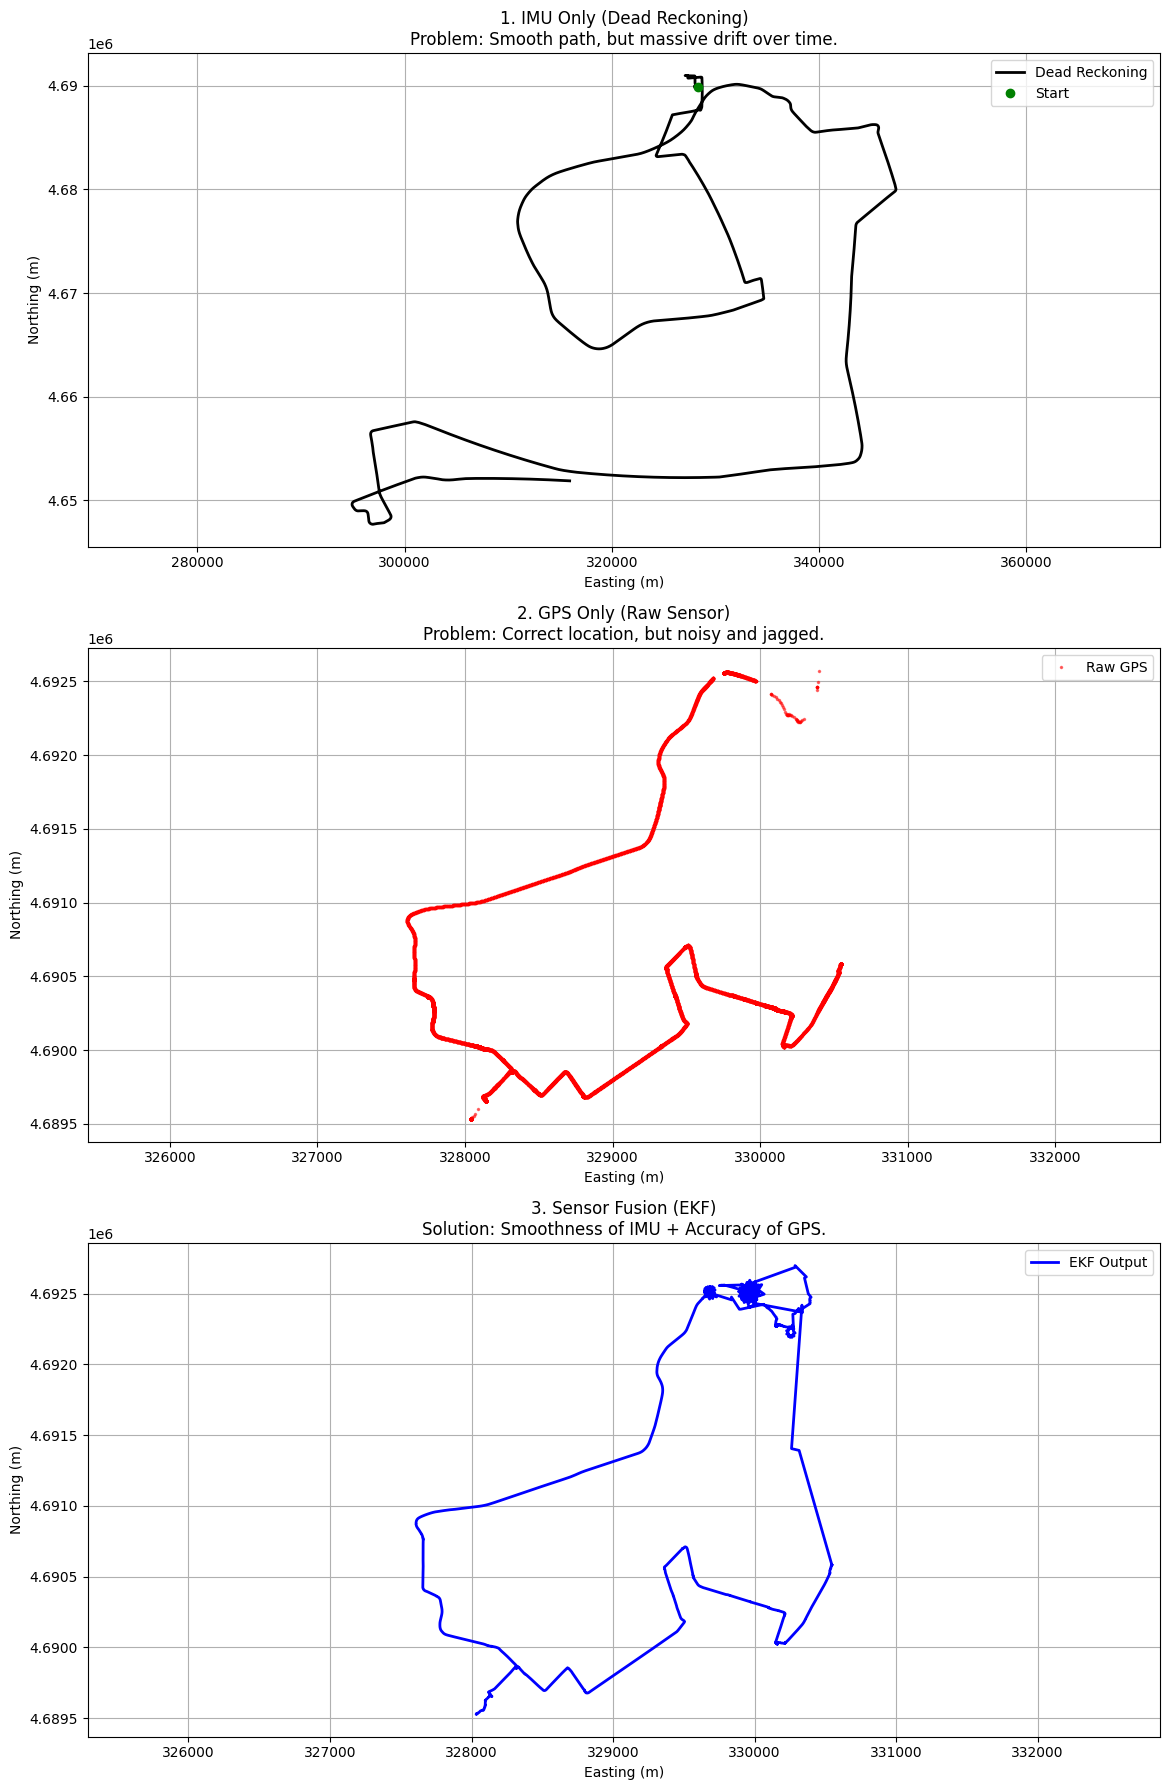

In [12]:
## DEAD RECKONING (IMU ONLY) CALCULATION
# Initialize state at the first GPS point
dr_x = Easting[0]
dr_y = Northing[0]
dr_theta = 0.0 # Assuming start facing East (0 rad)
dr_v = 0.0     # Assuming start from valid stop

# History lists
dr_path_x = []
dr_path_y = []

for i in range(len(timeimu)):
    # 1. Get Control Inputs (Unbiased IMU)
    a_x = accel_x_unbiased[i]
    omega = gyro_z_unbiased[i]
    
    # 2. Calculate dt (Time step)
    current_dt = 0.01 
    if i > 0:
        current_dt = timeimu[i] - timeimu[i-1]
        
    # 3. Physics Model (Double Integration)
    # Update Angle
    dr_theta += omega * current_dt
    
    # Update Velocity
    dr_v += a_x * current_dt
    
    # Update Position
    dr_x += dr_v * np.cos(dr_theta) * current_dt
    dr_y += dr_v * np.sin(dr_theta) * current_dt
    
    # Store
    dr_path_x.append(dr_x)
    dr_path_y.append(dr_y)


plt.figure(figsize=(12, 18))

# Top Plot: Dead Reckoning (IMU)
plt.subplot(3, 1, 1)
plt.plot(dr_path_x, dr_path_y, 'k-', linewidth=2, label='Dead Reckoning')
plt.plot(Easting[0], Northing[0], 'go', label='Start') # Mark Start
plt.title('1. IMU Only (Dead Reckoning)\nProblem: Smooth path, but massive drift over time.')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.axis('equal')
plt.grid(True)
plt.legend()

# Middle Plot: Raw GPS
plt.subplot(3, 1, 2)
plt.plot(Easting, Northing, 'r.', markersize=3, alpha=0.5, label='Raw GPS')
plt.title('2. GPS Only (Raw Sensor)\nProblem: Correct location, but noisy and jagged.')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.axis('equal')
plt.grid(True)
plt.legend()

# Bottom Plot: EKF Result
plt.subplot(3, 1, 3)
plt.plot(est_x, est_y, 'b-', linewidth=2, label='EKF Output')
plt.title('3. Sensor Fusion (EKF)\nSolution: Smoothness of IMU + Accuracy of GPS.')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.axis('equal')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()